# Example: Covertype Data Set

The following example uses the (processed) Covertype dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Covertype).

It is a dataset with both categorical (`wilderness_area` and `soil_type`) and continuous (the rest) features. The target is the `cover_type` column:

In [1]:
covertype_dataset = spark.read.parquet("covertype_dataset.snappy.parquet")

covertype_dataset.printSchema()

root
 |-- elevation: long (nullable = true)
 |-- aspect: long (nullable = true)
 |-- slope: long (nullable = true)
 |-- horizontal_distance_to_hydrology: long (nullable = true)
 |-- vertical_distance_to_hydrology: long (nullable = true)
 |-- horizontal_distance_to_roadways: long (nullable = true)
 |-- hillshade_9am: long (nullable = true)
 |-- hillshade_noon: long (nullable = true)
 |-- hillshade_3pm: long (nullable = true)
 |-- horizontal_distance_to_fire_points: long (nullable = true)
 |-- wilderness_area: string (nullable = true)
 |-- soil_type: string (nullable = true)
 |-- cover_type: string (nullable = true)



The 10 first rows:

In [2]:
covertype_dataset.limit(10).toPandas()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,wilderness_area,soil_type,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,rawah wilderness area,Soil_Type_7745,Aspen
1,2590,56,2,212,-6,390,220,235,151,6225,rawah wilderness area,Soil_Type_7745,Aspen
2,2804,139,9,268,65,3180,234,238,135,6121,rawah wilderness area,Soil_Type_4744,Lodgepole Pine
3,2785,155,18,242,118,3090,238,238,122,6211,rawah wilderness area,Soil_Type_7746,Lodgepole Pine
4,2595,45,2,153,-1,391,220,234,150,6172,rawah wilderness area,Soil_Type_7745,Aspen
5,2579,132,6,300,-15,67,230,237,140,6031,rawah wilderness area,Soil_Type_7745,Lodgepole Pine
6,2606,45,7,270,5,633,222,225,138,6256,rawah wilderness area,Soil_Type_7745,Aspen
7,2605,49,4,234,7,573,222,230,144,6228,rawah wilderness area,Soil_Type_7745,Aspen
8,2617,45,9,240,56,666,223,221,133,6244,rawah wilderness area,Soil_Type_7745,Aspen
9,2612,59,10,247,11,636,228,219,124,6230,rawah wilderness area,Soil_Type_7745,Aspen


In order for Spark's `DecisionTreeClassifier` to work with the categorical features (as well as the target), we first need to use [`pyspark.ml.feature.StringIndexer`](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.StringIndexer)s to generate a numeric representation for those columns:

In [3]:
from pyspark.ml.feature import StringIndexer

string_indexer_wilderness = StringIndexer(inputCol="wilderness_area", outputCol="wilderness_area_indexed")

string_indexer_soil = StringIndexer(inputCol="soil_type", outputCol="soil_type_indexed")
                                    
string_indexer_cover = StringIndexer(inputCol="cover_type", outputCol="cover_type_indexed")

To generate the new *StringIndexerModels*, we call `.fit()` on each `StringIndexer` instance:

In [4]:
string_indexer_wilderness_model = string_indexer_wilderness.fit(covertype_dataset)

string_indexer_soil_model = string_indexer_soil.fit(covertype_dataset)

string_indexer_cover_model = string_indexer_cover.fit(covertype_dataset)

And we create the new columns:

In [5]:
covertype_dataset_indexed_features = string_indexer_cover_model.transform(string_indexer_soil_model
                                                                          .transform(string_indexer_wilderness_model
                                                                                     .transform(covertype_dataset)
                                                                                    )
                                                                         )

New columns can be seen at the right:

In [6]:
covertype_dataset_indexed_features.limit(10).toPandas()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,wilderness_area,soil_type,cover_type,wilderness_area_indexed,soil_type_indexed,cover_type_indexed
0,2596,51,3,258,0,510,221,232,148,6279,rawah wilderness area,Soil_Type_7745,Aspen,0.0,0.0,5.0
1,2590,56,2,212,-6,390,220,235,151,6225,rawah wilderness area,Soil_Type_7745,Aspen,0.0,0.0,5.0
2,2804,139,9,268,65,3180,234,238,135,6121,rawah wilderness area,Soil_Type_4744,Lodgepole Pine,0.0,7.0,0.0
3,2785,155,18,242,118,3090,238,238,122,6211,rawah wilderness area,Soil_Type_7746,Lodgepole Pine,0.0,6.0,0.0
4,2595,45,2,153,-1,391,220,234,150,6172,rawah wilderness area,Soil_Type_7745,Aspen,0.0,0.0,5.0
5,2579,132,6,300,-15,67,230,237,140,6031,rawah wilderness area,Soil_Type_7745,Lodgepole Pine,0.0,0.0,0.0
6,2606,45,7,270,5,633,222,225,138,6256,rawah wilderness area,Soil_Type_7745,Aspen,0.0,0.0,5.0
7,2605,49,4,234,7,573,222,230,144,6228,rawah wilderness area,Soil_Type_7745,Aspen,0.0,0.0,5.0
8,2617,45,9,240,56,666,223,221,133,6244,rawah wilderness area,Soil_Type_7745,Aspen,0.0,0.0,5.0
9,2612,59,10,247,11,636,228,219,124,6230,rawah wilderness area,Soil_Type_7745,Aspen,0.0,0.0,5.0


Now, we just have to `VectorAssemble` our features to create the feature vector:

In [7]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["elevation",
                   "aspect",
                   "slope",
                   "horizontal_distance_to_hydrology",
                   "vertical_distance_to_hydrology",
                   "horizontal_distance_to_roadways",
                   "hillshade_9am",
                   "hillshade_noon",
                   "hillshade_3pm",
                   "horizontal_distance_to_fire_points",
                   "wilderness_area_indexed",
                   "soil_type_indexed"]

feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

And we have our dataset prepared for ML:

In [8]:
covertype_dataset_prepared = feature_assembler.transform(covertype_dataset_indexed_features)

In [9]:
covertype_dataset_prepared.printSchema()

root
 |-- elevation: long (nullable = true)
 |-- aspect: long (nullable = true)
 |-- slope: long (nullable = true)
 |-- horizontal_distance_to_hydrology: long (nullable = true)
 |-- vertical_distance_to_hydrology: long (nullable = true)
 |-- horizontal_distance_to_roadways: long (nullable = true)
 |-- hillshade_9am: long (nullable = true)
 |-- hillshade_noon: long (nullable = true)
 |-- hillshade_3pm: long (nullable = true)
 |-- horizontal_distance_to_fire_points: long (nullable = true)
 |-- wilderness_area: string (nullable = true)
 |-- soil_type: string (nullable = true)
 |-- cover_type: string (nullable = true)
 |-- wilderness_area_indexed: double (nullable = true)
 |-- soil_type_indexed: double (nullable = true)
 |-- cover_type_indexed: double (nullable = true)
 |-- features: vector (nullable = true)



Let's build a simple `pyspark.ml.classification.DecisionTreeClassifier`:

In [10]:
from pyspark.ml.classification import DecisionTreeClassifier

dtree = DecisionTreeClassifier(featuresCol="features",
                               labelCol="cover_type_indexed",
                               maxDepth=3,
                               maxBins=50)

We fit it, and we get our `DecisionTreeClassificationModel`:

In [11]:
dtree_model = dtree.fit(covertype_dataset_prepared)

dtree_model

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4e4bb7e3ef5c9d7a879d) of depth 3 with 15 nodes

The `.toDebugString` attribute prints the decision rules for the tree, but it is not very user-friendly:

In [12]:
print(dtree_model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4e4bb7e3ef5c9d7a879d) of depth 3 with 15 nodes
  If (feature 0 <= 3045.0)
   If (feature 0 <= 2539.0)
    If (feature 10 in {1.0,2.0})
     Predict: 2.0
    Else (feature 10 not in {1.0,2.0})
     Predict: 0.0
   Else (feature 0 > 2539.0)
    If (feature 11 in {0.0,2.0,6.0,7.0,8.0,10.0,12.0,13.0,19.0,22.0,24.0,25.0,27.0,29.0,30.0,31.0,32.0,36.0,38.0})
     Predict: 0.0
    Else (feature 11 not in {0.0,2.0,6.0,7.0,8.0,10.0,12.0,13.0,19.0,22.0,24.0,25.0,27.0,29.0,30.0,31.0,32.0,36.0,38.0})
     Predict: 0.0
  Else (feature 0 > 3045.0)
   If (feature 0 <= 3313.0)
    If (feature 11 in {1.0,4.0,5.0,7.0,8.0,9.0,10.0,11.0,12.0,15.0,20.0,23.0,24.0,25.0,27.0,32.0,34.0,35.0,37.0})
     Predict: 1.0
    Else (feature 11 not in {1.0,4.0,5.0,7.0,8.0,9.0,10.0,11.0,12.0,15.0,20.0,23.0,24.0,25.0,27.0,32.0,34.0,35.0,37.0})
     Predict: 1.0
   Else (feature 0 > 3313.0)
    If (feature 10 in {1.0})
     Predict: 3.0
    Else (feature 10 not in

Perhaps `spark_tree_plotting` may be helpful here ;)

In [13]:
from spark_tree_plotting import plot_tree

tree_plot = plot_tree(dtree_model,
                      featureNames=feature_columns,
                      categoryNames={"wilderness_area_indexed":string_indexer_wilderness_model.labels,
                                     "soil_type_indexed":string_indexer_soil_model.labels},
                      classNames=string_indexer_cover_model.labels,
                      filled=True,          # With color!
                      roundedCorners=True,  # Rounded corners in the nodes
                      roundLeaves=True      # Leaves will be ellipses instead of rectangles
                     )

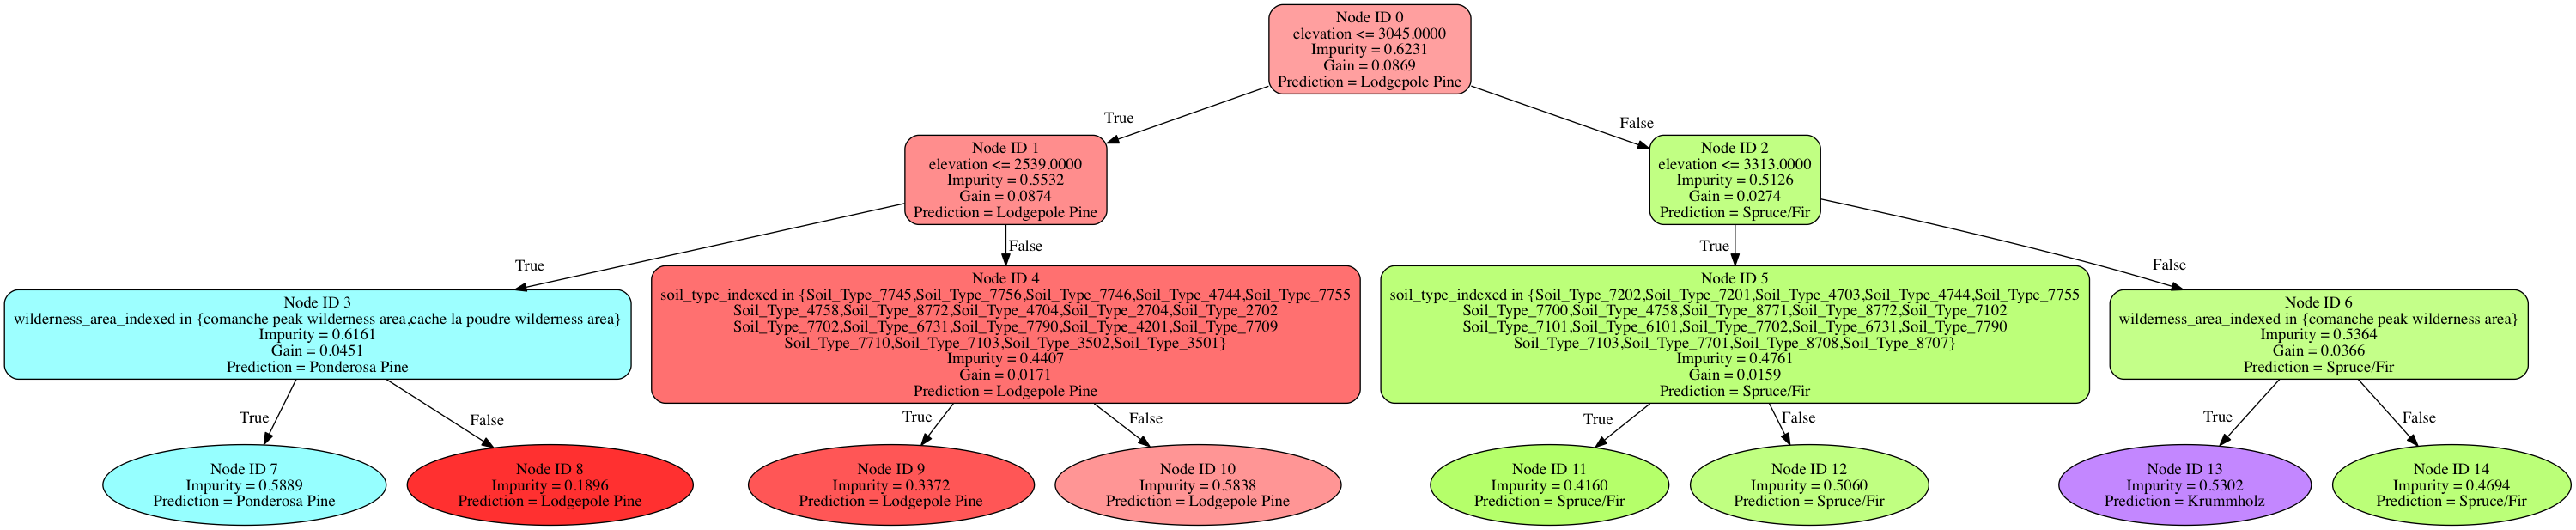

In [14]:
from IPython.display import Image

Image(tree_plot)